<a href="https://colab.research.google.com/github/alexandre-cameron-borges/duda_cohortscore/blob/main/data_and_finetuning_cohort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJET DUDA COHORTSCORE**

---



# 1 - Partie Analyse exploratoire

Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


Import du dataset contenant au minimum 200 000 lignes, avec une diversité de données numériques, catégorielles et temporelles

In [ ]:
# Configurer l’API Kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/credentials/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Télécharger & dézipper les jeux Kaggle
!kaggle datasets download -d yasserh/instacart-online-grocery-basket-analysis-dataset \
    -p /content/drive/MyDrive/data/raw --unzip

In [ ]:
base_path = "/content/drive/MyDrive/data/raw/instacart-online-grocery-basket-analysis-dataset"

orders = pd.read_csv(f"{base_path}/orders.csv")
products = pd.read_csv(f"{base_path}/products_with_prices.csv")
aisles = pd.read_csv(f"{base_path}/aisles.csv")
order_products_prior = pd.read_csv(f"{base_path}/order_products__prior.csv")
order_products_train = pd.read_csv(f"{base_path}/order_products__train.csv")


Decouverte exploratoire des données

orders.csv — consists of order details placed by any user — shape: (3421083, 7)


*   Order_id : Unique for every order
*   User_id : Unique for every user
*   Eval_set : ( prior / train / test)
*   Order_number : ith order placed by user
*   Order_dow : Day of week
*   Order_hour_of_day : Time of day in hr
*   Days_since_prior_order : difference in days between 2 orders

In [ ]:
print("ORDERS:")
display(orders.head())
print(orders.shape)

print("PRODUCTS:")
display(products.head())
print(products.shape)

print("AISLES:")
display(aisles.head())
print(aisles.shape)


ORDERS:


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

(3421083, 7)
PRODUCTS:


product_id                                    product_name  aisle_id  \
0           1                      Chocolate Sandwich Cookies        61   
1          10  Sparkling Orange Juice & Prickly Pear Beverage       115   
2         100         Peanut Butter & Strawberry Jam Sandwich        38   
3        1000                                        Apricots        18   
4       10000                   Refresher Strawberry Lemonade        64   

   department_id  price  
0             19  €4.38  
1              7  €2.25  
2              1  €2.97  
3             10  €3.15  
4              7  €2.74

(49688, 5)
AISLES:


aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

(134, 2)


Merge

In [ ]:
order_products_all = pd.concat([order_products_prior, order_products_train], ignore_index=True)
order_products_all.sort_values(by=["order_id", "add_to_cart_order"], inplace=True)
print("OPA:")
display(order_products_all.head())
print(order_products_all.shape)

OPA:


order_id  product_id  add_to_cart_order  reordered
32434489         1       49302                  1          1
32434490         1       11109                  2          1
32434491         1       10246                  3          0
32434492         1       49683                  4          0
32434493         1       43633                  5          1

(33819106, 4)


Nettoyage des données

In [ ]:
nan_counts = orders.isna().sum()
print("NaN orders :\n", nan_counts)

dup_total = orders.duplicated().sum()
print(f"Nombre de lignes dupliquées orders : {dup_total}")

nan_counts2 = products.isna().sum()
print("NaN products :\n", nan_counts2)

dup_total2 = products.duplicated().sum()
print(f"Nombre de lignes dupliquées products : {dup_total2}")

nan_counts3 = aisles.isna().sum()
print("NaN aisles :\n", nan_counts3)

dup_total3 = aisles.duplicated().sum()
print(f"Nombre de lignes dupliquées aisles : {dup_total3}")

nan_counts4 = order_products_all.isna().sum()
print("NaN opa :\n", nan_counts4)

dup_total4 = order_products_all.duplicated().sum()
print(f"Nombre de lignes dupliquées opa : {dup_total4}")

NaN orders :
 order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64
Nombre de lignes dupliquées orders : 0
NaN products :
 product_id       0
product_name     0
aisle_id         0
department_id    0
price            0
dtype: int64
Nombre de lignes dupliquées products : 0
NaN aisles :
 aisle_id    0
aisle       0
dtype: int64
Nombre de lignes dupliquées aisles : 0
NaN opa :
 order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
Nombre de lignes dupliquées opa : 0


In [ ]:
# Gérer les NaN en 0
orders["days_since_prior_order"] = orders["days_since_prior_order"].fillna(0)

Création des variables supplémentaires & 7 analyses

In [ ]:
## 2 Best sellers aisles & products

# Merge des produits avec les infos produits (nom, aisle, etc.)
merged = order_products_all.merge(products, on='product_id', how='left')

# Merge avec la table des rayons (aisles)
merged = merged.merge(aisles, on='aisle_id', how='left')

display(merged.head(20))
print(merged.shape)



order_id  product_id  add_to_cart_order  reordered  \
0          1       49302                  1          1   
1          1       11109                  2          1   
2          1       10246                  3          0   
3          1       49683                  4          0   
4          1       43633                  5          1   
5          1       13176                  6          0   
6          1       47209                  7          0   
7          1       22035                  8          1   
8          2       33120                  1          1   
9          2       28985                  2          1   
10         2        9327                  3          0   
11         2       45918                  4          1   
12         2       30035                  5          0   
13         2       17794                  6          1   
14         2       40141                  7          1   
15         2        1819                  8          1   
16         2       43668                  9          0   
17         3       33754                  1          1   
18         3       24838                  2          1   
19         3       17704                  3          1   

                                         product_name  aisle_id  \
0                                    Bulgarian Yogurt       120   
1       Organic 4% Milk Fat Whole Milk Cottage Cheese       108   
2                               Organic Celery Hearts        83   
3                                      Cucumber Kirby        83   
4                Lightly Smoked Sardines in Olive Oil        95   
5                              Bag of Organic Bananas        24   
6                                Organic Hass Avocado        24   
7                         Organic Whole String Cheese        21   
8                                  Organic Egg Whites        86   
9                               Michigan Organic Kale        83   
10                                      Garlic Powder       104   
11                                     Coconut Butter        19   
12                                  Natural Sweetener        17   
13                                            Carrots        83   
14                   Original Unflavored Gelatine Mix       105   
15           All Natural No Stir Creamy Almond Butter        88   
16                            Classic Blend Cole Slaw       123   
17  Total 2% with Strawberry Lowfat Greek Strained...       120   
18                             Unsweetened Almondmilk        91   
19                                             Lemons       123   

    department_id  price                       aisle  
0              16  €3.39                      yogurt  
1              16  €4.34        other creams cheeses  
2               4  €4.64            fresh vegetables  
3               4  €3.11            fresh vegetables  
4              15  €7.45         canned meat seafood  
5               4  €0.90                fresh fruits  
6               4  €3.84                fresh fruits  
7              16  €4.66             packaged cheese  
8              16  €4.52                        eggs  
9               4  €1.99            fresh vegetables  
10             13  €3.22           spices seasonings  
11             13  €4.14               oils vinegars  
12             13  €2.96          baking ingredients  
13              4  €1.87            fresh vegetables  
14             13  €5.85  doughs gelatins bake mixes  
15             13  €2.18                     spreads  
16              4  €4.61  packaged vegetables fruits  
17             16  €2.22                      yogurt  
18             16  €3.48             soy lactosefree  
19              4  €2.49  packaged vegetables fruits

(33819106, 9)


In [ ]:
# Nettoyage de la colonne prix
merged["price"] = merged["price"].replace('[€]', '', regex=True).astype(float)
display(merged.head(20))

order_id  product_id  add_to_cart_order  reordered  \
0          1       49302                  1          1   
1          1       11109                  2          1   
2          1       10246                  3          0   
3          1       49683                  4          0   
4          1       43633                  5          1   
5          1       13176                  6          0   
6          1       47209                  7          0   
7          1       22035                  8          1   
8          2       33120                  1          1   
9          2       28985                  2          1   
10         2        9327                  3          0   
11         2       45918                  4          1   
12         2       30035                  5          0   
13         2       17794                  6          1   
14         2       40141                  7          1   
15         2        1819                  8          1   
16         2       43668                  9          0   
17         3       33754                  1          1   
18         3       24838                  2          1   
19         3       17704                  3          1   

                                         product_name  aisle_id  \
0                                    Bulgarian Yogurt       120   
1       Organic 4% Milk Fat Whole Milk Cottage Cheese       108   
2                               Organic Celery Hearts        83   
3                                      Cucumber Kirby        83   
4                Lightly Smoked Sardines in Olive Oil        95   
5                              Bag of Organic Bananas        24   
6                                Organic Hass Avocado        24   
7                         Organic Whole String Cheese        21   
8                                  Organic Egg Whites        86   
9                               Michigan Organic Kale        83   
10                                      Garlic Powder       104   
11                                     Coconut Butter        19   
12                                  Natural Sweetener        17   
13                                            Carrots        83   
14                   Original Unflavored Gelatine Mix       105   
15           All Natural No Stir Creamy Almond Butter        88   
16                            Classic Blend Cole Slaw       123   
17  Total 2% with Strawberry Lowfat Greek Strained...       120   
18                             Unsweetened Almondmilk        91   
19                                             Lemons       123   

    department_id  price                       aisle  
0              16   3.39                      yogurt  
1              16   4.34        other creams cheeses  
2               4   4.64            fresh vegetables  
3               4   3.11            fresh vegetables  
4              15   7.45         canned meat seafood  
5               4   0.90                fresh fruits  
6               4   3.84                fresh fruits  
7              16   4.66             packaged cheese  
8              16   4.52                        eggs  
9               4   1.99            fresh vegetables  
10             13   3.22           spices seasonings  
11             13   4.14               oils vinegars  
12             13   2.96          baking ingredients  
13              4   1.87            fresh vegetables  
14             13   5.85  doughs gelatins bake mixes  
15             13   2.18                     spreads  
16              4   4.61  packaged vegetables fruits  
17             16   2.22                      yogurt  
18             16   3.48             soy lactosefree  
19              4   2.49  packaged vegetables fruits

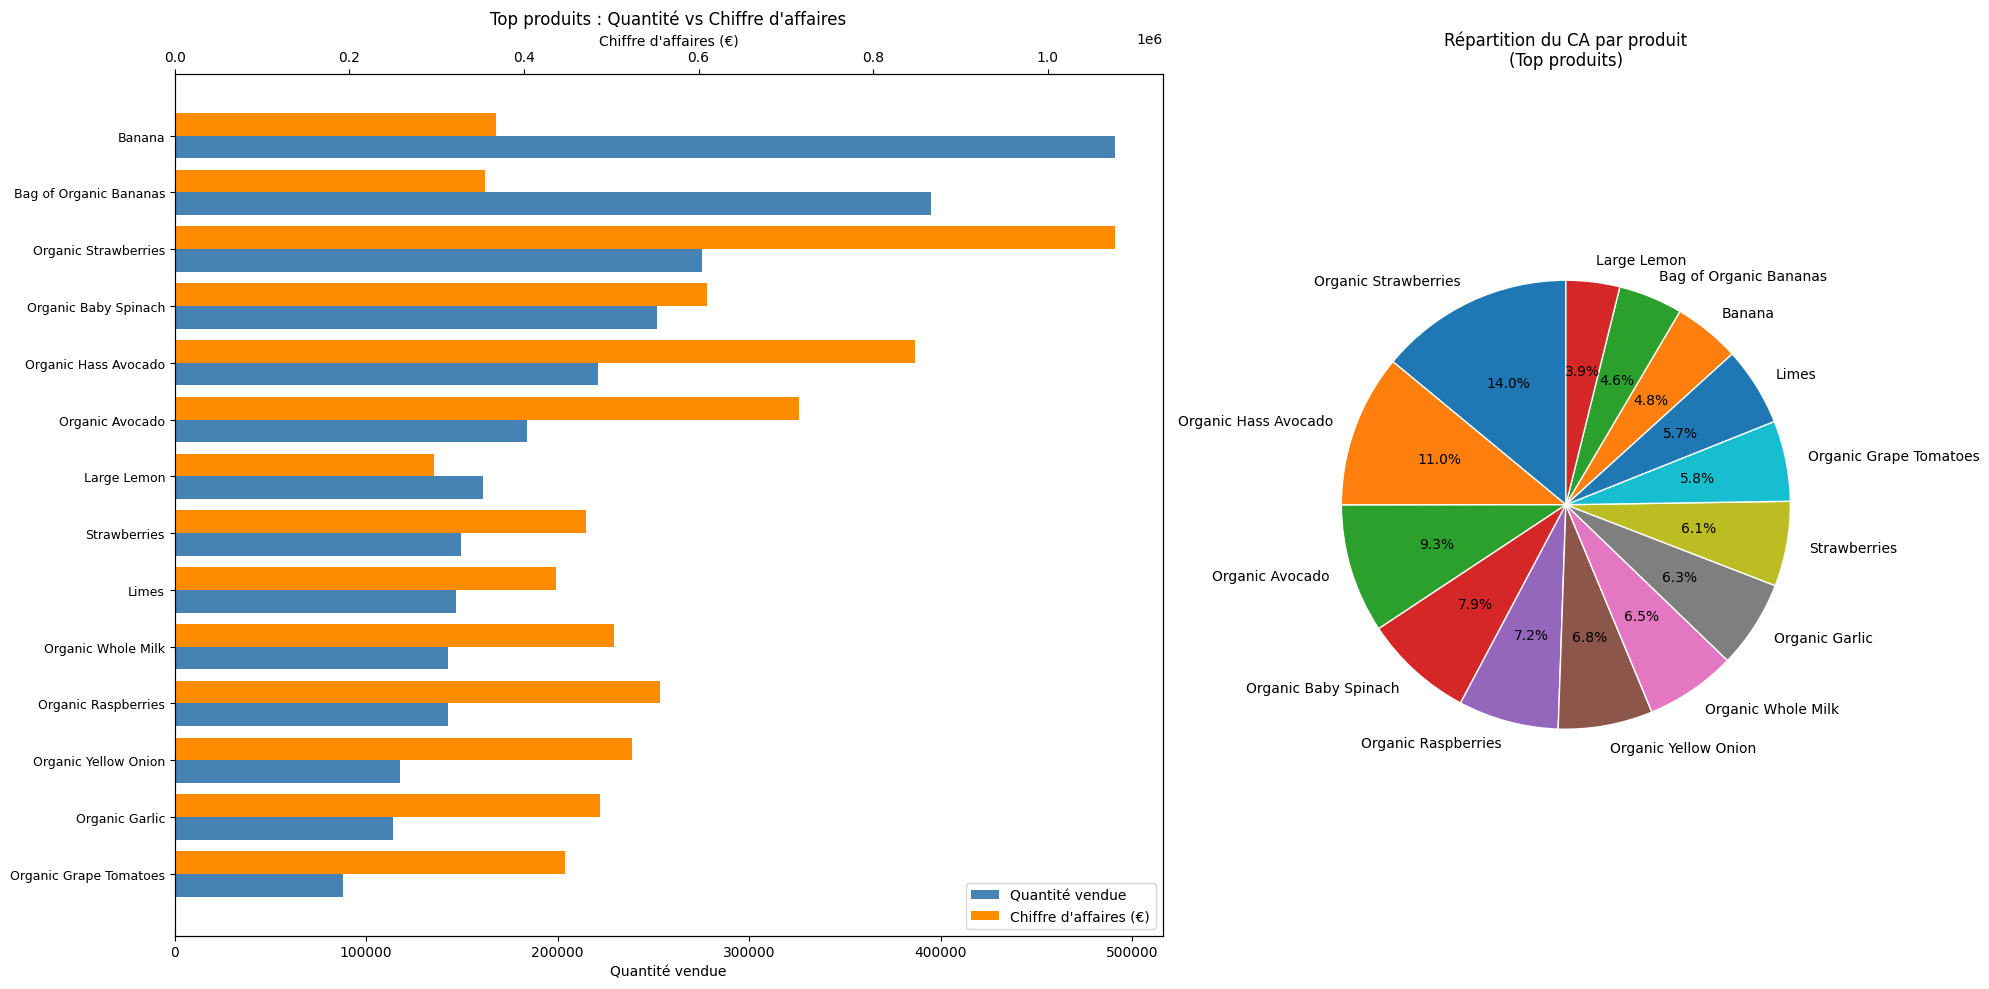

In [ ]:


# 2) Top 12 produits par quantité et CA
top_qty_prod = (
    merged
    .groupby('product_name')
    .size()
    .reset_index(name='total_qty')
    .nlargest(12, 'total_qty')
)
top_rev_prod = (
    merged
    .groupby('product_name')['price']
    .sum()
    .reset_index(name='total_rev')
    .nlargest(10, 'total_rev')
)

# 3) Union des produits
prods = pd.Index(top_qty_prod['product_name']).union(top_rev_prod['product_name'])

# 4) Recalcul des métriques sur cet ensemble
df_prod = (
    merged
    .groupby('product_name')
    .agg(
        total_qty=('order_id', 'count'),
        total_rev=('price',   'sum')
    )
    .loc[prods]
    .sort_values('total_qty', ascending=True)
)

# 5) Figure en deux panneaux
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(20, 10),
    gridspec_kw={'width_ratios': [2, 1]}
)

y = list(range(len(df_prod)))

# — Panel 1 : barres dual-axe Quantité vs CA
bars1 = ax1.barh(
    [i - 0.2 for i in y],
    df_prod['total_qty'],
    height=0.4,
    color='steelblue',
    label='Quantité vendue'
)
ax1.set_yticks(y)
ax1.set_yticklabels(df_prod.index, fontsize=9)
ax1.set_xlabel('Quantité vendue')

ax1_tw = ax1.twiny()
bars2 = ax1_tw.barh(
    [i + 0.2 for i in y],
    df_prod['total_rev'],
    height=0.4,
    color='darkorange',
    label="Chiffre d'affaires (€)"
)
ax1_tw.set_xlabel("Chiffre d'affaires (€)")

# Légende combinée
handles = [bars1, bars2]
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='lower right')

ax1.set_title("Top produits : Quantité vs Chiffre d'affaires")

# — Panel 2 : camembert du CA

ordered = df_prod['total_rev'].sort_values(ascending=False)
ax2.pie(
    ordered.values,
    autopct='%1.1f%%',
    labels=ordered.index,
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)


ax2.axis('equal')
ax2.set_title("Répartition du CA par produit\n(Top produits)")

plt.tight_layout()
plt.show()


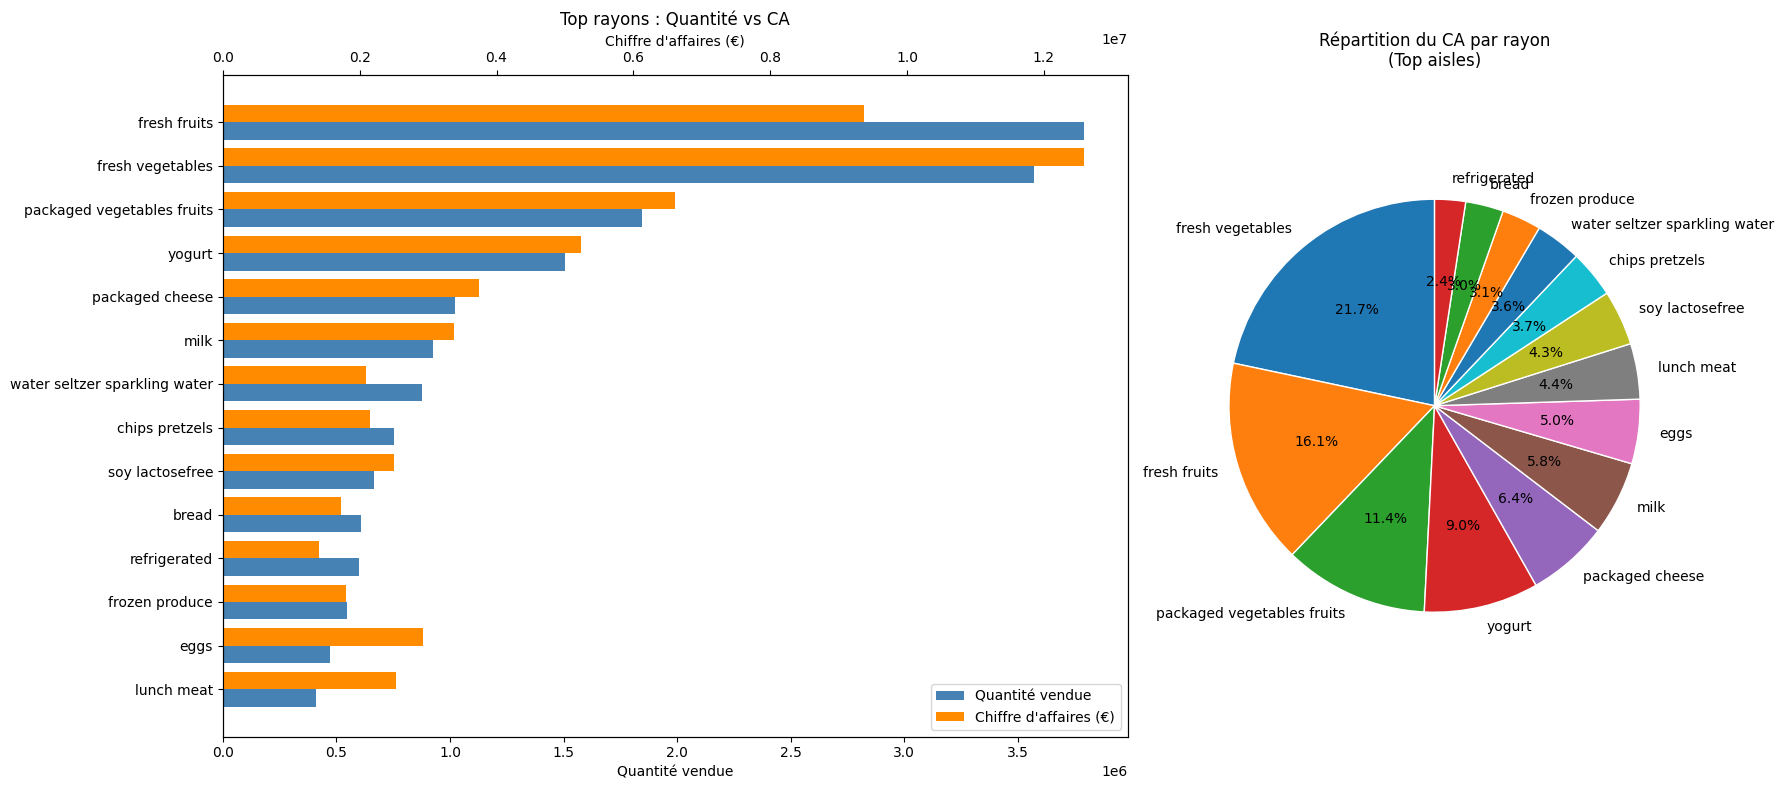

In [ ]:


# 2) Top 12 par quantité et par CA
top_qty_aisle = (
    merged
    .groupby('aisle')
    .size()
    .reset_index(name='total_qty')
    .nlargest(12, 'total_qty')
)
top_rev_aisle = (
    merged
    .groupby('aisle')['price']
    .sum()
    .reset_index(name='total_rev')
    .nlargest(12, 'total_rev')
)

# 3) Union des rayons et recalcul des métriques
aisles = pd.Index(top_qty_aisle['aisle']).union(top_rev_aisle['aisle'])
df_aisle = (
    merged
    .groupby('aisle')
    .agg(
        total_qty=('order_id', 'count'),
        total_rev=('price',   'sum')
    )
    .loc[aisles]
    .sort_values('total_qty', ascending=True)
)

# 4) Figure à deux panneaux
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(18, 8),
    gridspec_kw={'width_ratios': [2, 1]}
)

y = list(range(len(df_aisle)))

# — Panel 1 : dual-axe Quantité vs CA
bars1 = ax1.barh(
    [i - 0.2 for i in y],
    df_aisle['total_qty'],
    height=0.4,
    color='steelblue',
    label='Quantité vendue'
)
ax1.set_yticks(y)
ax1.set_yticklabels(df_aisle.index)
ax1.set_xlabel('Quantité vendue')

ax2b = ax1.twiny()
bars2 = ax2b.barh(
    [i + 0.2 for i in y],
    df_aisle['total_rev'],
    height=0.4,
    color='darkorange',
    label="Chiffre d'affaires (€)"
)
ax2b.set_xlabel("Chiffre d'affaires (€)")

handles = [bars1, bars2]
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='lower right')

ax1.set_title("Top rayons : Quantité vs CA")

# — Panel 2 : pie chart du CA
orderedaisles = df_aisle['total_rev'].sort_values(ascending=False)
ax2.pie(
    orderedaisles.values,
    labels=orderedaisles.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
ax2.axis('equal')  # pour un cercle parfait
ax2.set_title("Répartition du CA par rayon\n(Top aisles)")

plt.tight_layout()
plt.show()


In [ ]:
# Fusion de orders avec order_products_all
full_data = merged.merge(orders, on='order_id', how='left')

# 2 Best moments (day and hour)

top_hours = full_data.groupby('order_hour_of_day')['product_id'].count()
top_days = full_data.groupby('order_dow')['product_id'].count()


# Matrice Jour x Heure (nombre de produits commandés)
sales_matrix = (
    full_data
    .groupby(["order_dow", "order_hour_of_day"])
    .size()
    .unstack(fill_value=0)
)

day_names = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
sales_matrix.index = day_names

# Remplacer l’index de top_days par les noms
top_days.index = [day_names[d] for d in top_days.index]

sales_thousands = sales_matrix / 1000

<ipython-input-13-002ccb6b929b>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-13-002ccb6b929b>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


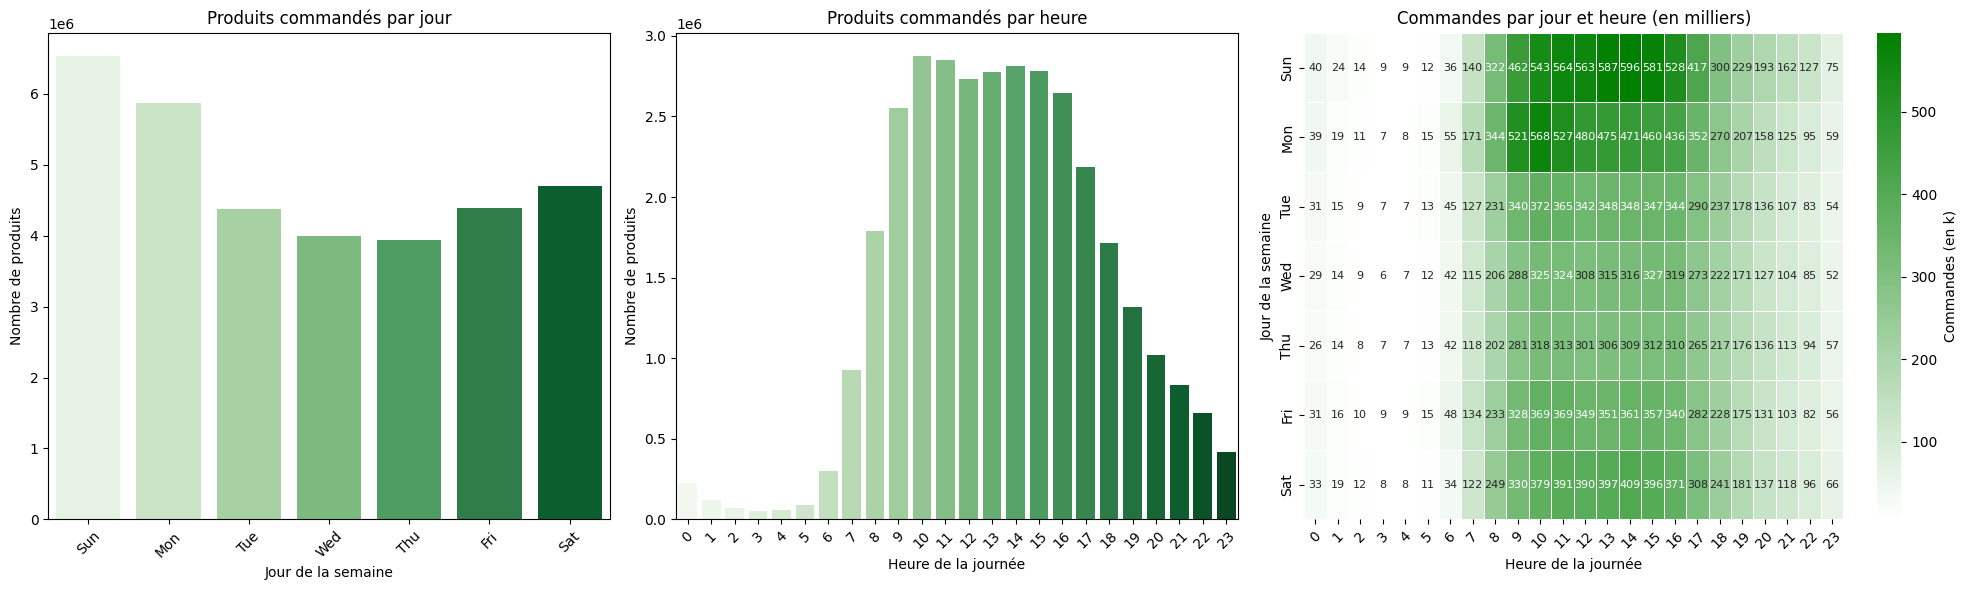

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Création de la figure avec 3 sous-graphes
fig, axes = plt.subplots(
    1, 3,
    figsize=(20, 6),
    gridspec_kw={'width_ratios': [1, 1, 1.2]}
)

# 1) Histogramme : produits commandés par jour
sns.barplot(
    x=top_days.index,
    y=top_days.values,
    palette='Greens',
    ax=axes[0]
)
axes[0].set_title("Produits commandés par jour")
axes[0].set_xlabel("Jour de la semaine")
axes[0].set_ylabel("Nombre de produits")
axes[0].tick_params(axis='x', rotation=45)

# 2) Histogramme : produits commandés par heure
sns.barplot(
    x=top_hours.index,
    y=top_hours.values,
    palette='Greens',
    ax=axes[1]
)
axes[1].set_title("Produits commandés par heure")
axes[1].set_xlabel("Heure de la journée")
axes[1].set_ylabel("Nombre de produits")
axes[1].tick_params(axis='x', rotation=45)

# 3) Heatmap : commandes jour x heure en milliers
cmap_wg = LinearSegmentedColormap.from_list('RedGreen', ['white','green'])
sns.heatmap(
    sales_thousands,
    cmap=cmap_wg,
    annot=True,
    fmt='.0f',
    annot_kws={'fontsize':8},
    cbar_kws={'label': 'Commandes (en k)'},
    linewidths=0.5,
    linecolor='white',
    ax=axes[2]
)
axes[2].set_title("Commandes par jour et heure (en milliers)")
axes[2].set_xlabel("Heure de la journée")
axes[2].set_ylabel("Jour de la semaine")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# 3 RFM Cluster





In [ ]:
# 1. Copie de full_data
df = full_data.copy()

# 2. Gérer les NaN de la 1ʳᵉ commande → 0 jour avant
df["days_since_prior_order"] = df["days_since_prior_order"].fillna(0)

# 3. Ordonner pour chaque utilisateur
df = df.sort_values(["user_id", "order_number"])

# 5. Calculer Recency (Récence de la dernière commande)
recency = (
    df
    .groupby("user_id")["days_since_prior_order"]
    .nunique()
    .reset_index(name="Recency")
)

# 6. Calculer Frequency (nombre total de commandes)
frequency = (
    df
    .groupby("user_id")["order_number"]
    .nunique()
    .reset_index(name="Frequency")
)

# 7. Calculer Monetary (€ total dépensé)
#    (adaptez si vous avez un champ `price * quantity`)
monetary = (
    df
    .groupby("user_id")["price"]
    .sum()
    .reset_index(name="Monetary")
)

# 8. Merge final RFM
rfm = recency.merge(frequency, on="user_id") \
               .merge(monetary, on="user_id")

# 9. Aperçu
print(rfm.head())
print(rfm.info())
print(rfm.describe())


   user_id  Recency  Frequency  Monetary
0        1        9         11    235.86
1        2       10         15    849.62
2        3        9         12    303.20
3        4        4          5     57.65
4        5        5          5    175.97
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    206209 non-null  int64  
 1   Recency    206209 non-null  int64  
 2   Frequency  206209 non-null  int64  
 3   Monetary   206209 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 6.3 MB
None
             user_id        Recency      Frequency       Monetary
count  206209.000000  206209.000000  206209.000000  206209.000000
mean   103105.000000       8.335014      16.226658     605.655212
std     59527.555167       4.598329      16.662238     758.289973
min         1.000000       1.000000       3.000000       3.030000
25%     51553

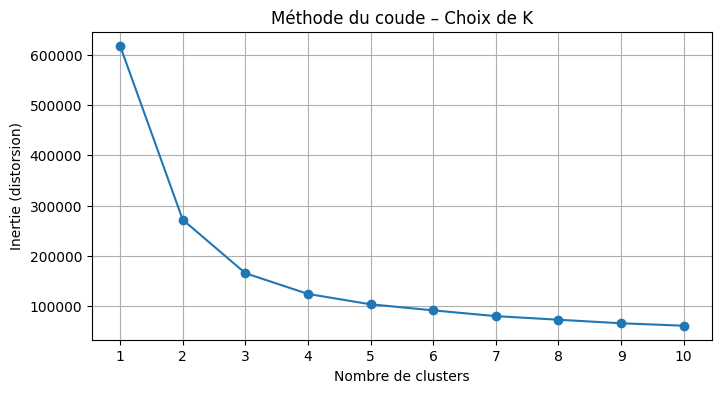

In [ ]:
# CLUSTERING

from sklearn.preprocessing import StandardScaler

# Choix : soit RFM bruts, soit scores (plus simple à interpréter)
X = rfm[["Recency", "Frequency", "Monetary"]].copy()

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 11)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)

# Courbe du coude
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title("Méthode du coude – Choix de K")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie (distorsion)")
plt.xticks(K_range)
plt.grid(True)
plt.show()



In [ ]:
# Choix du K où la courbe commence à "plier" : souvent entre 3 et 6.
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(X_scaled)


In [ ]:
# Moyenne des variables RFM par cluster
cluster_summary = (
    rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]]
    .median()
    .round(1)
    .sort_values("Monetary", ascending=False)
)

# 1. Calculer le nombre de clients par cluster
cluster_counts = rfm.groupby("Cluster").size().rename("Count")

# 2. Joindre ce décompte à votre summary existant
cluster_summary_with_count = (
    cluster_summary
    .join(cluster_counts)                   # ajoute la colonne Count
    .sort_values("Monetary", ascending=False)  # tri facultatif
)

# 3. Afficher le résultat
display(cluster_summary_with_count)


Recency  Frequency  Monetary   Count
Cluster                                      
1           13.0       64.0    2829.4   10030
3           15.0       32.0    1162.3   33628
0           10.0       15.0     483.9   58169
2            4.0        6.0     177.9  104382

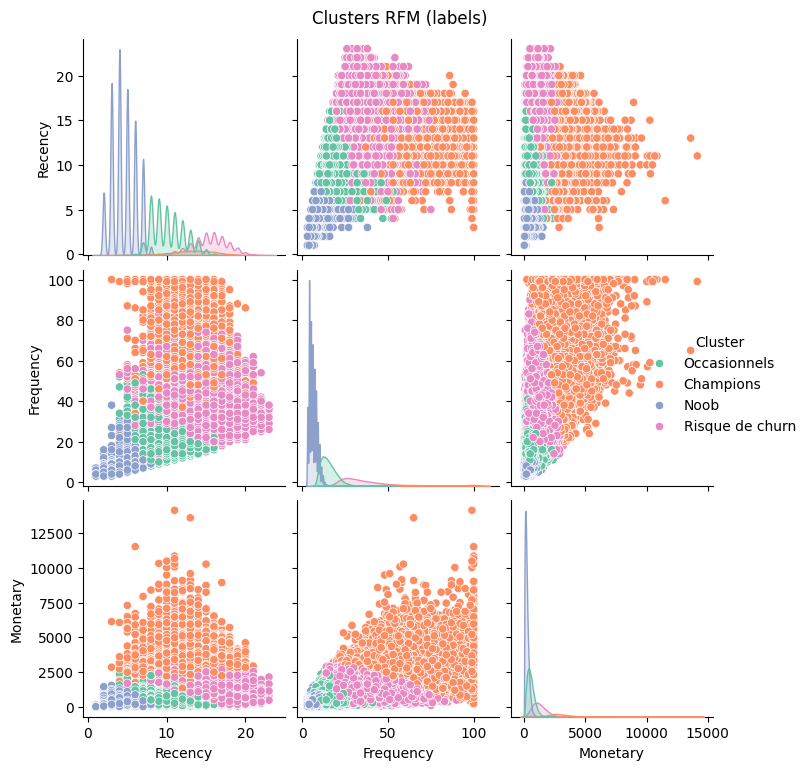

In [ ]:
# 1. Tracez d’abord votre pairplot
g = sns.pairplot(
    rfm,
    vars=["Recency", "Frequency", "Monetary"],
    hue="Cluster",
    palette="Set2"
)

# 2. Dictionnaire de mapping (int → str)
label_dict = {
    0: "Occasionnels",
    1: "Champions",
    2: "Noob",
    3: "Risque de churn"
}

# 3. Remplacez les textes de légende
for text in g._legend.texts:
    orig = text.get_text()
    # vérifie si c’est un chiffre, puis remplace
    if orig.isdigit():
        text.set_text(label_dict[int(orig)])

plt.suptitle("Clusters RFM (labels)", y=1.02)
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go

# Nombre de clusters (ici 6)
n_clusters = rfm["Cluster"].nunique()

# Récupération de la liste de couleurs Set2
palette = sns.color_palette("Set2", n_clusters)

# Si vos labels de cluster sont 0,1,2,3,4,5 (sinon trier ou renuméroter)
cluster_labels = sorted(rfm["Cluster"].unique())
color_dict = dict(zip(cluster_labels, palette))


<ipython-input-20-ed7178c1cbc9>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(
/usr/local/lib/python3.11/dist-packages/matplotlib/collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


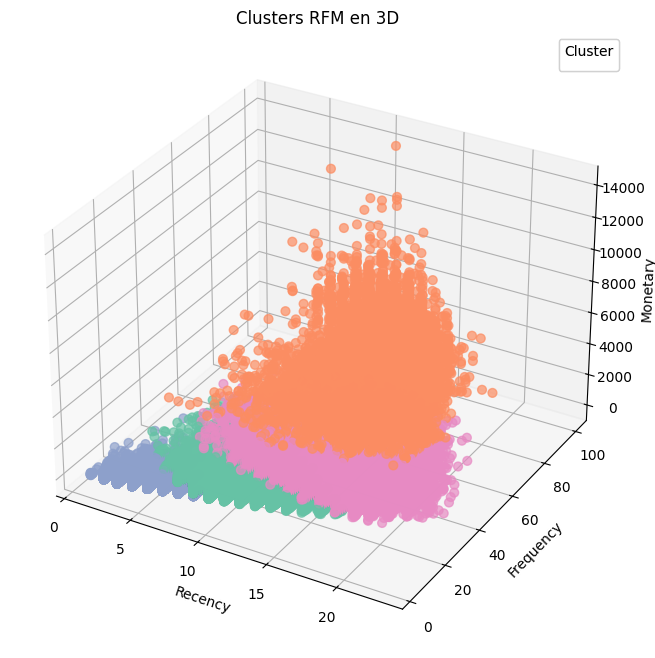

In [ ]:
# ––––––––––––––––––––––––––––––––––––––––––––––––––
fig = plt.figure(figsize=(10, 8))
ax  = fig.add_subplot(111, projection='3d')
colors = rfm["Cluster"].map(color_dict)


sc = ax.scatter(
    rfm["Recency"],
    rfm["Frequency"],
    rfm["Monetary"],
    c=colors,
    cmap="Set2",       # palette discrète
    s=40,              # taille des points
    alpha=0.7          # transparence
)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("Clusters RFM en 3D")

# Légende automatique des clusters
legend1 = ax.legend(
    *sc.legend_elements(),
    title="Cluster"
)
ax.add_artist(legend1)

plt.show()

In [ ]:
from matplotlib.colors import rgb2hex

hex_palette = [rgb2hex(color) for color in palette]

fig = px.scatter_3d(
    rfm,
    x="Recency", y="Frequency", z="Monetary",
    color="Cluster",
    color_discrete_sequence=hex_palette,
    size_max=6,
    opacity=0.7,
    title="Clusters RFM Interactif (Set2)"
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()

Export

In [ ]:
# 2. Importer os pour créer le dossier si nécessaire
import os

# 1) Construire la table finale
final_df = full_data.merge(
    rfm[['user_id', 'Recency', 'Frequency', 'Monetary', 'Cluster']],
    on='user_id',
    how='left'
)

drive_dir = '/content/drive/MyDrive/data/raw'


In [ ]:




# 3. Exporter le CSV
output_path = os.path.join(drive_dir, 'instacart_cleaned.csv')
final_df.to_csv(output_path, index=False)

print(f"CSV nettoyé exporté vers : {output_path}")


CSV nettoyé exporté vers : /content/drive/MyDrive/data/raw/instacart_cleaned.csv


In [ ]:
df_sample = final_df.sample(n=500000)
output_path = os.path.join(drive_dir, 'instacart_cleaned_mini.csv')
df_sample.to_csv(output_path, index=False)

print(f"CSV nettoyé exporté vers : {output_path}")

CSV nettoyé exporté vers : /content/drive/MyDrive/data/raw/instacart_cleaned_mini.csv


In [ ]:

output_path2 = os.path.join(drive_dir, 'instacart_sample_500k.parquet')
df_sample.to_parquet(output_path2, index=False)

print(f"Parquet nettoyé exporté vers : {output_path2}")

Parquet nettoyé exporté vers : /content/drive/MyDrive/data/raw/instacart_sample_500k.parquet


Visualisation avec filtres dynamiques sur l'app.py streamlit

# 2 - Partie text mining

Prétraitement du texte (nettoyage, tokenisation, suppression des stopwords, etc.)

WordCloud